# Advanced Tables for JWST

###  Tom Aldcroft    --      2016-Nov-10

### User Training in JWST Data Analysis II 

# Table design goals and requirements

- Easily mutable container of heterogeneous tabular data
- Relatively lightweight yet powerful enough for most needs
- Responsive to astronomy community needs
  - For JWST community - if something is missing, broken, needs improvement then ASK!
- Deep integration with Astropy (I/O, units, quantity)
- Persistent metadata (column units, table header keywords, formatting)
- Support missing data

# Why doesn't Astropy use Pandas DataFrame?

- Easily mutable container of heterogeneous tabular data **(only scalar data)**
- **Relatively lightweight** yet powerful enough for most needs
- Responsive to **astronomy community** needs
- **Deep integration with Astropy (I/O, units, quantity)**
- **Persistent metadata (column units, table header keywords, formatting)**
- Support missing data: **Pandas will cast ``int`` types to ``float64`` to use ``NaN``**
  - Large ``int64`` values lose precision
  - Short int (e.g. ``uint8``) values take 4 times as much memory as ``MaskedColumn``

### Nevertheless...

We recognize Pandas is very fast, powerful and widely used.

*Astropy Project recommendation is to use `astropy.Table` where possible.  This especially applies to community packages.*


# Example: multiband photometry of a field

### Observations in 5 bands of a single field with 5 "galaxy-like" sources

- Assumes basic image reduction and source detection is done.
- Could be similar to JWST post-image processing workflow.

### Key Table concepts to be covered

- Basic table structure (dict of independent column objects)
- Base column class properties and attributes (flexibility in data elements)
- Table mutability and formatting
- Database operations: join, grouping, binning, stacking, indexing
- Missing data
- Mixin columns (Quantity, Time, Coordinates, QTable vs. Table)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy
from astropy import table
from astropy.table import Column, Table, QTable
from astropy.time import Time
import astropy.units as u
import photutils.datasets
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
astropy.__version__

'1.2.1'

### Make table of  5 random gaussians corresponding to fake elliptical galaxy-like sources

Use a photutils utility function [make_random_gaussians](http://photutils.readthedocs.io/en/stable/api/photutils.datasets.make_random_gaussians.html).

In [3]:
sources = photutils.datasets.make_random_gaussians(
    flux_range=(1000, 10000), n_sources=5, 
    xmean_range=(10, 190), ymean_range=(10, 190),
    xstddev_range=(2, 5), ystddev_range=(2,5),
    random_state=1)

In [4]:
sources

flux,x_mean,y_mean,x_stddev,y_stddev,theta
float64,float64,float64,float64,float64,float64
4753.19804232,26.6209470584,85.4550125926,4.01140253054,4.40223370603,5.62097944383
7482.92044098,43.526838048,133.339510071,3.2519144071,4.90478472716,0.534348539339
1001.02937336,72.2009308677,46.8014049517,3.67606948534,2.94027253448,0.245388440184
3720.99315369,81.4181453615,168.06113855,2.42116081579,4.07696784701,1.06707599692
2320.80301735,106.987012121,14.9297667756,2.59430446725,4.62916745689,5.51753207516


### Digression: learn a little about the Table and Column objects

- `Table` is a **container class** where `Table.columns` is the main table data structure
- `Table.columns` is an OrderedDict of columns (`Column`, `MaskedColumn`, or mixin-column)
- `Column` class inherits from `np.ndarray`
- `MaskedColumn` class inherits from `np.ma.MaskedArray`

In [5]:
type(sources.columns).__mro__

(astropy.table.table.TableColumns, collections.OrderedDict, dict, object)

In [6]:
type(sources.columns['flux']).__mro__

(astropy.table.column.Column,
 astropy.table.column.BaseColumn,
 astropy.table._column_mixins._ColumnGetitemShim,
 numpy.ndarray,
 object)

In [7]:
sources.columns['flux'] is sources['flux']

True

### Make a synthetic image for cutouts

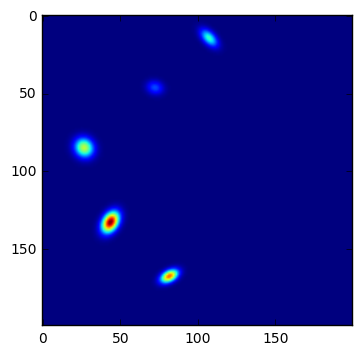

In [8]:
img = photutils.datasets.make_gaussian_sources(image_shape=(200, 200), 
                                               source_table=sources)
plt.imshow(img);  # Trick: trailing semicolon to suppress output

### Make postage-stamp cutouts for each source

In [9]:
# Make integer columns with rounded representation of source mean position 

sources['x0'] = np.round(sources['x_mean']).astype(int)
sources['y0'] = np.round(sources['y_mean']).astype(int)

In [10]:
# Generate list of cutout images around each source

npix = 10
cutouts = [img[y0-npix:y0+npix, x0-npix:x0+npix] for x0, y0 in sources['x0', 'y0']]

# `cutouts` is a list of 2-d ndarrays

In [11]:
# Add the cutouts into table: each element is a 2-d image
# This shows:
#  - Table mutability and independent columns
#  - Storage of ndarray in each table cell

sources['cutout'] = cutouts

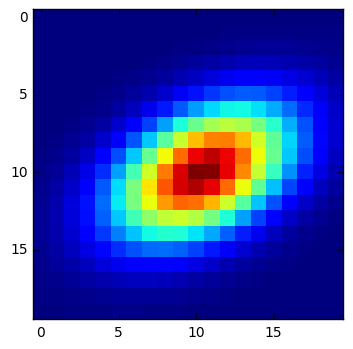

In [12]:
plt.imshow(sources['cutout'][3], interpolation='nearest');

### Add a source identifier to the table

In [13]:
sources['id'] = ['jwst-{}-{}'.format(x0, y0) for x0, y0 in sources['x0', 'y0']]
sources

flux,x_mean,y_mean,x_stddev,y_stddev,theta,x0,y0,"cutout [20,20]",id
float64,float64,float64,float64,float64,float64,int64,int64,float64,str11
4753.19804232,26.6209470584,85.4550125926,4.01140253054,4.40223370603,5.62097944383,27,85,0.232716683083 .. 0.656931179953,jwst-27-85
7482.92044098,43.526838048,133.339510071,3.2519144071,4.90478472716,0.534348539339,44,133,0.0100611670495 .. 0.0371331355371,jwst-44-133
1001.02937336,72.2009308677,46.8014049517,3.67606948534,2.94027253448,0.245388440184,72,47,0.00320277411248 .. 0.0140636535326,jwst-72-47
3720.99315369,81.4181453615,168.06113855,2.42116081579,4.07696784701,1.06707599692,81,168,2.78324370053e-06 .. 0.000216688721074,jwst-81-168
2320.80301735,106.987012121,14.9297667756,2.59430446725,4.62916745689,5.51753207516,107,15,0.299126306154 .. 0.676275001635,jwst-107-15


### Formatting: let's be a little fussy about the Table:
- Put the 'id' column first
- Make the precision of table outputs more reasonable (and beautiful!)
- Add units to `flux` and `theta` columns



In [14]:
# Move the `id` column to be the first column 
# (Should Table get a method `move_column` to make this easier?)
sources_id = sources['id']
del sources['id']
sources.add_column(sources_id, index=0)

# Set the output formatting for particular columns
for name in ('flux', 'x_mean', 'y_mean', 'x_stddev', 'y_stddev', 'theta'):
    sources[name].format = '.3f'  # Could also use '%.3f' or '{:.3f}'
sources['cutout'].format = '.3g'

# Set the unit for flux and theta
sources['flux'].unit = u.electron
sources['theta'].unit = u.rad

sources

id,flux,x_mean,y_mean,x_stddev,y_stddev,theta,x0,y0,"cutout [20,20]"
,electron,,,,,rad,,,
str11,float64,float64,float64,float64,float64,float64,int64,int64,float64
jwst-27-85,4753.198,26.621,85.455,4.011,4.402,5.621,27,85,0.233 .. 0.657
jwst-44-133,7482.920,43.527,133.340,3.252,4.905,0.534,44,133,0.0101 .. 0.0371
jwst-72-47,1001.029,72.201,46.801,3.676,2.940,0.245,72,47,0.0032 .. 0.0141
jwst-81-168,3720.993,81.418,168.061,2.421,4.077,1.067,81,168,2.78e-06 .. 0.000217
jwst-107-15,2320.803,106.987,14.930,2.594,4.629,5.518,107,15,0.299 .. 0.676


### Digression: table and column summary information

In [15]:
sources.info

<Table length=5>
  name    dtype   shape     unit   format
-------- ------- -------- -------- ------
      id   str11                         
    flux float64          electron    .3f
  x_mean float64                      .3f
  y_mean float64                      .3f
x_stddev float64                      .3f
y_stddev float64                      .3f
   theta float64               rad    .3f
      x0   int64                         
      y0   int64                         
  cutout float64 (20, 20)             .3g

In [16]:
sources.info('stats')
# You can write your own info specifications!

<Table length=5>
  name        mean          std              min             max     
-------- ------------- -------------- ----------------- -------------
      id            --             --                --            --
    flux 3855.78880554  2212.93605386     1001.02937336 7482.92044098
  x_mean 66.1507746912  28.3257658899     26.6209470584 106.987012121
  y_mean 89.7173665883  55.6664540236     14.9297667756  168.06113855
x_stddev  3.1909703412 0.610042819261     2.42116081579 4.01140253054
y_stddev 4.19068525431 0.681677499286     2.94027253448 4.90478472716
   theta 2.59706489909   2.4412797746    0.245388440184 5.62097944383
      x0          66.2  28.0955512493                27           107
      y0          89.6  55.5539377542                15           168
  cutout 9.37452077298  13.4002193774 2.78324370053e-06 74.0353588184


In [17]:
# You can roll your own custom info!

from astropy.utils.data_info import data_info_factory
mystats = data_info_factory(names=['my_min', 'my_median', 'my_max'],
                            funcs=[np.min, np.median, np.max])
sources.info(mystats)

<Table length=5>
  name         my_min        my_median       my_max   
-------- ----------------- ------------- -------------
      id                --            --            --
    flux     1001.02937336 3720.99315369 7482.92044098
  x_mean     26.6209470584 72.2009308677 106.987012121
  y_mean     14.9297667756 85.4550125926  168.06113855
x_stddev     2.42116081579  3.2519144071 4.01140253054
y_stddev     2.94027253448 4.40223370603 4.90478472716
   theta    0.245388440184 1.06707599692 5.62097944383
      x0                27          72.0           107
      y0                15          85.0           168
  cutout 2.78324370053e-06 3.45394975925 74.0353588184


#### Column info: name, dtype, unit, format, description

In [18]:
sources['theta'].info.description = 'Elliptical gaussian rotation angle'
sources['theta'].info

name = theta
dtype = float64
unit = rad
format = .3f
description = Elliptical gaussian rotation angle
class = Column
n_bad = 0
length = 5

### Make fake observations of these sources in 5 bands 'u', 'b', 'v', 'r', 'k'

In [19]:
def make_observation(sources, band, flux_mult):
    """
    Make fake observation of ``sources`` in a field in ``band``.  Apply
    ``flux_mult`` flux multiplier and some gaussian noise on parameters.
    """
    n = len(sources)
    out = sources.copy()

    # Multiply flux by randomized version of flux_mult
    out['flux'] *= flux_mult * np.random.normal(loc=1, scale=0.1, size=n)

    # Add 1.0 pixel of position and stddev noise
    for name in ('x_mean', 'y_mean'):
        out[name] += np.random.normal(loc=0, scale=1.0, size=n)
  
    # Add 0.1 pixel noise to stddev
    for name in ('x_stddev', 'y_stddev'):
        out[name] += np.random.normal(loc=0, scale=0.1, size=n)
        
    # Add a list that repeats the ``band`` as the second column
    out.add_column(Column([band] * n, name='band'), index=1)
    
    # Make integer columns with rounded representation of source mean position  
    sources['x0'] = np.round(sources['x_mean']).astype(int)
    sources['y0'] = np.round(sources['y_mean']).astype(int)
    
    # Generate list of cutout images around each source
    img = photutils.datasets.make_gaussian_sources(image_shape=(200, 200), source_table=out)
    npix = 10
    cutouts = [img[y0-npix:y0+npix, x0-npix:x0+npix] for x0, y0 in sources['x0', 'y0']]
    sources['cutout'] = cutouts

    return out

In [20]:
sources_list = []
for band, flux_mult in [('u', 0.1), 
                        ('b', 0.2), 
                        ('v', 0.5), 
                        ('r', 1.0), 
                        ('k', 1.5)]:
    sources_list.append(make_observation(sources, band, flux_mult))
    
sources_list[0]

# Notice that the formatting and units got inherited into our new tables

id,band,flux,x_mean,y_mean,x_stddev,y_stddev,theta,x0,y0,"cutout [20,20]"
,,electron,,,,,rad,,,
str11,str1,float64,float64,float64,float64,float64,float64,int64,int64,float64
jwst-27-85,u,400.427,25.498,84.417,4.000,4.347,5.621,27,85,0.233 .. 0.657
jwst-44-133,u,848.570,43.931,135.088,3.082,4.776,0.534,44,133,0.0101 .. 0.0371
jwst-72-47,u,109.775,71.245,45.827,3.673,2.994,0.245,72,47,0.0032 .. 0.0141
jwst-81-168,u,333.263,82.401,170.258,2.417,3.983,1.067,81,168,2.78e-06 .. 0.000217
jwst-107-15,u,185.181,106.098,13.677,2.462,4.664,5.518,107,15,0.299 .. 0.676


In [21]:
# Pretend that there are non-detections in some bands

sources_list[0].remove_rows([1,2,3,4])
sources_list[1].remove_row(1)
sources_list[3].remove_row(0)

## Database-like features for more power: vstack, indexing, group and join

Our list of source tables **`sources_list`** has the raw data we need for analysis but is inconvenient.  Things we'd like to do:

- Find all observations of a particular source
- List all sources in a particular band
- Compute statistics for a particular source (mean centroid, mean image cutout)
- Make a single wide table organized by source

See [Table high-level operations](http://docs.astropy.org/en/stable/table/operations.html) for all the details.

### Stacking

In [22]:
# Stack the list of tables to create a single table (database) of every source observation.

srcs = table.vstack(sources_list)

srcs

id,band,flux,x_mean,y_mean,x_stddev,y_stddev,theta,x0,y0,"cutout [20,20]"
,,electron,,,,,rad,,,
str11,str1,float64,float64,float64,float64,float64,float64,int64,int64,float64
jwst-27-85,u,400.427,25.498,84.417,4.000,4.347,5.621,27,85,0.233 .. 0.657
jwst-27-85,b,887.356,27.016,86.662,4.107,4.433,5.621,27,85,0.0516 .. 0.0169
jwst-72-47,b,162.792,71.571,45.789,3.655,2.966,0.245,72,47,0.00177 .. 0.000352
jwst-81-168,b,779.235,82.053,167.492,2.503,3.980,1.067,81,168,5.21e-10 .. 0.0015
jwst-107-15,b,550.330,107.263,16.152,2.720,4.579,5.518,107,15,0.0667 .. 0.0233
jwst-27-85,v,2038.269,26.453,85.094,4.077,4.490,5.621,27,85,0.0189 .. 0.246
jwst-44-133,v,4184.019,42.259,132.699,3.187,4.933,0.534,44,133,0.000166 .. 0.0946
jwst-72-47,v,520.755,72.665,47.680,3.857,2.905,0.245,72,47,0.00204 .. 0.000561


### Indexing

- Indexing means that supplemental information (an index) is added to the table that allows access to particular elements in `time << O(N)`.  
- In the case of astropy Table it uses a binary search of an ordered index table `O(log(N))`.

In [23]:
# Now add a database index on the `id` column.  This becomes the 'primary key'.
# In this case it does not need to be unique, though one can declare that an
# index must be unique.

srcs.add_index('id')

In [24]:
# Now access elements with id == 'jwst-27-85'.  This should be familiar to Pandas users.
# This returns another Table.

srcs.loc['jwst-27-85']

id,band,flux,x_mean,y_mean,x_stddev,y_stddev,theta,x0,y0,"cutout [20,20]"
,,electron,,,,,rad,,,
str11,str1,float64,float64,float64,float64,float64,float64,int64,int64,float64
jwst-27-85,v,2038.269,26.453,85.094,4.077,4.490,5.621,27,85,0.0189 .. 0.246
jwst-27-85,b,887.356,27.016,86.662,4.107,4.433,5.621,27,85,0.0516 .. 0.0169
jwst-27-85,k,5922.410,26.052,85.520,4.057,4.409,5.621,27,85,0.311 .. 0.466
jwst-27-85,u,400.427,25.498,84.417,4.000,4.347,5.621,27,85,0.233 .. 0.657


In [25]:
# Let's make a secondary index to allow slicing the table by band
srcs.add_index('band')

In [26]:
# Get a table of all 'b' band source detections

srcs.loc['band', 'b']

id,band,flux,x_mean,y_mean,x_stddev,y_stddev,theta,x0,y0,"cutout [20,20]"
,,electron,,,,,rad,,,
str11,str1,float64,float64,float64,float64,float64,float64,int64,int64,float64
jwst-27-85,b,887.356,27.016,86.662,4.107,4.433,5.621,27,85,0.0516 .. 0.0169
jwst-72-47,b,162.792,71.571,45.789,3.655,2.966,0.245,72,47,0.00177 .. 0.000352
jwst-81-168,b,779.235,82.053,167.492,2.503,3.980,1.067,81,168,5.21e-10 .. 0.0015
jwst-107-15,b,550.330,107.263,16.152,2.720,4.579,5.518,107,15,0.0667 .. 0.0233


In [27]:
# A special case is if only one table row is selected, in which case
# a Row object is returned.  This is convenient for the common use case
# of a table with unique keys.

srcs.loc['band', 'u']

id,band,flux,x_mean,y_mean,x_stddev,y_stddev,theta,x0,y0,"cutout [20,20]"
,,electron,,,,,rad,,,
str11,str1,float64,float64,float64,float64,float64,float64,int64,int64,float64
jwst-27-85,u,400.427,25.498,84.417,4.000,4.347,5.621,27,85,0.233 .. 0.657


### Digression: difference between Row and length=1 Table

- Indexing a single element of a table returns a `Row` object which can be used to set or access a column value.  This always returns a scalar value.
- Indexing a single row slice of a table returns a Table, so accessing a column returns a `Column` object (an array) with a length of 1.
- This is consistent with numpy structured arrays and Pandas (`df.ix[0]` vs. `df[0:1]`).

In [28]:
srcs[0]['band']

'u'

In [29]:
srcs[0:1]['band']

u


### Digression: table access performance

**``srcs[0:1]['band']``** and **``srcs['band'][0:1]``** give the same output, but performance is very different!

In [30]:
# This creates an entire new Table object (slow) and then selects one column (fast)
%timeit srcs[0:1]['band']

1000 loops, best of 3: 710 µs per loop


In [31]:
# This selects a column (fast) and then slices it (fast-ish, creates new Column)
%timeit srcs['band'][0:1]

10000 loops, best of 3: 25.7 µs per loop


In [32]:
# For the most performance, drop the `Column` machinery (no metadata) and use a straight numpy array

%timeit np.array(srcs['band'], copy=False)[0:1]

The slowest run took 7.35 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 2.59 µs per loop


### Grouping

Astropy `Table` supports the powerful concept of grouping which lets you group the rows into sub-tables which you can then:

- [Examine](http://docs.astropy.org/en/stable/table/operations.html#manipulating-groups): select and loop over groups
- [Aggregate](http://docs.astropy.org/en/stable/table/operations.html#aggregation): apply a reduction function like np.mean to each group
- [Filter](http://docs.astropy.org/en/stable/table/operations.html#filtering): select groups by means a selection function

This is a close cousin to indexing, and if a table is already indexed then creating the grouped version is faster.

In [33]:
srcs_grouped = srcs.group_by('id')

# srcs_grouped has all the same rows but now ordered by ``id``
srcs_grouped

id,band,flux,x_mean,y_mean,x_stddev,y_stddev,theta,x0,y0,"cutout [20,20]"
,,electron,,,,,rad,,,
str11,str1,float64,float64,float64,float64,float64,float64,int64,int64,float64
jwst-107-15,v,1189.844,108.783,15.429,2.708,4.735,5.518,107,15,0.0293 .. 0.254
jwst-107-15,r,2504.249,105.725,12.781,2.653,4.483,5.518,107,15,0.0549 .. 0.876
jwst-107-15,b,550.330,107.263,16.152,2.720,4.579,5.518,107,15,0.0667 .. 0.0233
jwst-107-15,k,3530.180,108.097,15.153,2.582,4.799,5.518,107,15,1.08 .. 0.105
jwst-27-85,v,2038.269,26.453,85.094,4.077,4.490,5.621,27,85,0.0189 .. 0.246
jwst-27-85,b,887.356,27.016,86.662,4.107,4.433,5.621,27,85,0.0516 .. 0.0169
jwst-27-85,k,5922.410,26.052,85.520,4.057,4.409,5.621,27,85,0.311 .. 0.466
jwst-27-85,u,400.427,25.498,84.417,4.000,4.347,5.621,27,85,0.233 .. 0.657


In [34]:
for src in srcs_grouped.groups:
    print(src)

     id     band   flux    x_mean y_mean ... theta  x0  y0  cutout [20,20] 
                 electron                ...  rad                          
----------- ---- -------- ------- ------ ... ----- --- --- ----------------
jwst-107-15    v 1189.844 108.783 15.429 ... 5.518 107  15  0.0293 .. 0.254
jwst-107-15    r 2504.249 105.725 12.781 ... 5.518 107  15  0.0549 .. 0.876
jwst-107-15    b  550.330 107.263 16.152 ... 5.518 107  15 0.0667 .. 0.0233
jwst-107-15    k 3530.180 108.097 15.153 ... 5.518 107  15    1.08 .. 0.105
    id     band   flux   x_mean y_mean ... theta  x0  y0  cutout [20,20] 
                electron               ...  rad                          
---------- ---- -------- ------ ------ ... ----- --- --- ----------------
jwst-27-85    v 2038.269 26.453 85.094 ... 5.621  27  85  0.0189 .. 0.246
jwst-27-85    b  887.356 27.016 86.662 ... 5.621  27  85 0.0516 .. 0.0169
jwst-27-85    k 5922.410 26.052 85.520 ... 5.621  27  85   0.311 .. 0.466
jwst-27-85    u  400.427

In [35]:
# Now let's make a new table where each row is the mean of all rows in the group

mean_srcs = srcs_grouped.groups.aggregate(np.mean)
mean_srcs

id,flux,x_mean,y_mean,x_stddev,y_stddev,theta,x0,y0
,electron,,,,,rad,,
str11,float64,float64,float64,float64,float64,float64,float64,float64
jwst-107-15,1943.651,107.467,14.879,2.665,4.649,5.518,107.0,15.0
jwst-27-85,2312.115,26.255,85.423,4.060,4.420,5.621,27.0,85.0
jwst-44-133,7861.715,43.190,133.328,3.255,4.894,0.534,44.0,133.0
jwst-72-47,795.773,71.922,46.625,3.744,2.941,0.245,72.0,47.0
jwst-81-168,3001.841,81.910,167.675,2.479,4.082,1.067,81.0,168.0


In [36]:
# We can define custom behavior depending on column type or even name

def sources_mean(arr):
    if arr.dtype.kind in ('S', 'U'):
        out= ', '.join(arr)
    elif arr.info.name == 'flux':
        # Take the log mean
        out = np.exp(np.mean(np.log(arr)))
    else:
        out = np.mean(arr, axis=0)

    return out

In [37]:
mean_srcs = srcs_grouped.groups.aggregate(sources_mean)
mean_srcs

id,band,flux,x_mean,y_mean,x_stddev,y_stddev,theta,x0,y0,"cutout [20,20]"
,,electron,,,,,rad,,,
str11,str10,float64,float64,float64,float64,float64,float64,float64,float64,float64
jwst-107-15,"v, r, b, k",1551.125,107.467,14.879,2.665,4.649,5.518,107.0,15.0,0.307 .. 0.315
jwst-27-85,"v, b, k, u",1439.114,26.255,85.423,4.060,4.420,5.621,27.0,85.0,0.154 .. 0.346
jwst-44-133,"v, r, k",7185.866,43.190,133.328,3.255,4.894,0.534,44.0,133.0,0.0114 .. 0.0465
jwst-72-47,"b, v, r, k",587.186,71.922,46.625,3.744,2.941,0.245,72.0,47.0,0.00301 .. 0.00808
jwst-81-168,"v, k, r, b",2333.101,81.910,167.675,2.479,4.082,1.067,81.0,168.0,9.86e-06 .. 0.000418


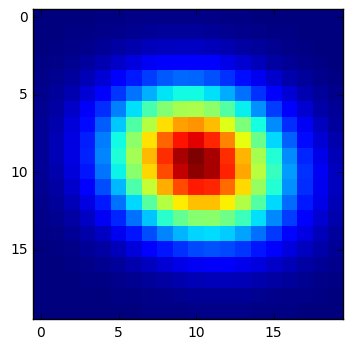

In [38]:
plt.imshow(mean_srcs['cutout'][3], interpolation='nearest')

### Digression: Binning

A common tool in analysis is to **bin** a table based on some reference value. Examples:

- Photometry of a binary star in several bands taken over a span of time which should be binned by orbital phase.
- Reducing the sampling density for a table by combining 100 rows at a time.
- Unevenly sampled historical data which should binned to four points per year.

The common theme in all these cases is to convert the key value array into a 
new `float`- or `int`-valued array whose values are identical for rows in the same output bin. As an example, generate a fake light curve:


In [39]:
year = np.linspace(2000.0, 2010.0, 200)  # 200 observations over 10 years
period = 1.811
y0 = 2005.2
mag = 14.0 + 1.2 * np.sin(2 * np.pi * (year - y0) / period) + np.random.normal(scale=0.1, size=200)
phase = ((year - y0) / period) % 1.0
dat = Table([year, phase, mag], names=['year', 'phase', 'mag'])

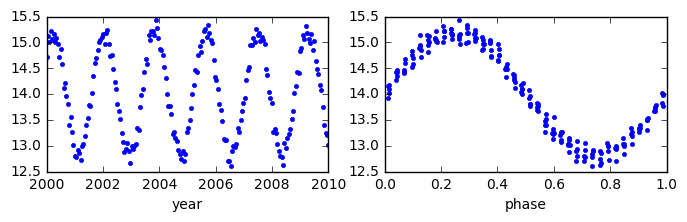

In [40]:
plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.plot(dat['year'], dat['mag'], '.')
plt.xlabel('year')
plt.subplot(1, 2, 2)
plt.xlabel('phase')
plt.plot(dat['phase'], dat['mag'], '.');

In [41]:
phase_bin = np.trunc(phase / 0.1)
phase_bin[:50]

array([ 1.,  1.,  1.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  4.,  4.,  4.,
        4.,  5.,  5.,  5.,  6.,  6.,  6.,  6.,  7.,  7.,  7.,  7.,  8.,
        8.,  8.,  9.,  9.,  9.,  9.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
        2.,  2.,  2.,  2.,  3.,  3.,  3.,  4.,  4.,  4.,  4.])

In [42]:
dat_grouped = dat.group_by(phase_bin)
dat_mean = dat_grouped.groups.aggregate(np.mean)
dat_std = dat_grouped.groups.aggregate(np.std)

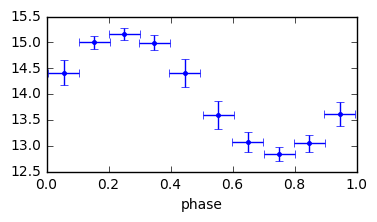

In [43]:
plt.figure(figsize=(4, 2))
plt.xlabel('phase')
plt.errorbar(x=dat_mean['phase'], xerr=0.05, y=dat_mean['mag'], yerr=dat_std['mag'], fmt='.');

### Join tables to make a single wide table by source `id`

- Have one row corresponding to each of the 5 sources
- Each row has columns with the 5 band u, b, v, r, k properties
- De-duplicate column names by labeling as `{colname}_{band}`

Because there are non-detections for some bands / sources, the result is a **Masked Table**.

In [44]:
sources_id = None
for left, right in zip(sources_list[:-1], sources_list[1:]):
    sources_id = table.join(left=sources_id or left,
                            right=right,
                            keys='id',
                            join_type='outer',
                            table_names=[left['band'][0], right['band'][0]])
sources_id

id,band_u,flux_u,x_mean_u,y_mean_u,x_stddev_u,y_stddev_u,theta_u,x0_u,y0_u,"cutout_u [20,20]",band_b,flux_b,x_mean_b,y_mean_b,x_stddev_b,y_stddev_b,theta_b,x0_b,y0_b,"cutout_b [20,20]",band_v,flux_v,x_mean_v,y_mean_v,x_stddev_v,y_stddev_v,theta_v,x0_v,y0_v,"cutout_v [20,20]",band_r,flux_r,x_mean_r,y_mean_r,x_stddev_r,y_stddev_r,theta_r,x0_r,y0_r,"cutout_r [20,20]",band,flux,x_mean,y_mean,x_stddev,y_stddev,theta,x0,y0,"cutout [20,20]"
,,electron,,,,,rad,,,,,electron,,,,,rad,,,,,electron,,,,,rad,,,,,electron,,,,,rad,,,,,electron,,,,,rad,,,
str11,str1,float64,float64,float64,float64,float64,float64,int64,int64,float64,str1,float64,float64,float64,float64,float64,float64,int64,int64,float64,str1,float64,float64,float64,float64,float64,float64,int64,int64,float64,str1,float64,float64,float64,float64,float64,float64,int64,int64,float64,str1,float64,float64,float64,float64,float64,float64,int64,int64,float64
jwst-107-15,--,--,--,--,--,--,--,--,--,-- .. --,b,550.330,107.263,16.152,2.720,4.579,5.518,107,15,0.0667 .. 0.0233,v,1189.844,108.783,15.429,2.708,4.735,5.518,107,15,0.0293 .. 0.254,r,2504.249,105.725,12.781,2.653,4.483,5.518,107,15,0.0549 .. 0.876,k,3530.180,108.097,15.153,2.582,4.799,5.518,107,15,1.08 .. 0.105
jwst-27-85,u,400.427,25.498,84.417,4.000,4.347,5.621,27,85,0.233 .. 0.657,b,887.356,27.016,86.662,4.107,4.433,5.621,27,85,0.0516 .. 0.0169,v,2038.269,26.453,85.094,4.077,4.490,5.621,27,85,0.0189 .. 0.246,--,--,--,--,--,--,--,--,--,-- .. --,k,5922.410,26.052,85.520,4.057,4.409,5.621,27,85,0.311 .. 0.466
jwst-44-133,--,--,--,--,--,--,--,--,--,-- .. --,--,--,--,--,--,--,--,--,--,-- .. --,v,4184.019,42.259,132.699,3.187,4.933,0.534,44,133,0.000166 .. 0.0946,r,7373.061,42.771,134.392,3.288,4.783,0.534,44,133,0.0235 .. 0.00246,k,12028.066,44.540,132.891,3.291,4.965,0.534,44,133,0.0105 .. 0.0425
jwst-72-47,--,--,--,--,--,--,--,--,--,-- .. --,b,162.792,71.571,45.789,3.655,2.966,0.245,72,47,0.00177 .. 0.000352,v,520.755,72.665,47.680,3.857,2.905,0.245,72,47,0.00204 .. 0.000561,r,850.218,71.992,45.844,3.638,2.990,0.245,72,47,0.000743 .. 0.0274,k,1649.326,71.460,47.185,3.827,2.905,0.245,72,47,0.0075 .. 0.00406
jwst-81-168,--,--,--,--,--,--,--,--,--,-- .. --,b,779.235,82.053,167.492,2.503,3.980,1.067,81,168,5.21e-10 .. 0.0015,v,1719.747,81.544,167.318,2.514,4.194,1.067,81,168,1.91e-06 .. 7.76e-05,r,4052.989,80.654,167.202,2.377,4.085,1.067,81,168,1.28e-05 .. 7.99e-05,k,5455.393,83.390,168.687,2.521,4.068,1.067,81,168,2.47e-05 .. 1.19e-05


In [45]:
# Inspect a masked element

sources_id.add_index('id')
sources_id.loc['jwst-44-133']['flux_u'] is np.ma.masked

True

## Astropy integration: quantities, units, mixin columns, QTable and all that

A major feature of astropy `Table` is integrated support for:

- ``Quantity`` columns that have meaningful units
- ``Time`` and ``Coordinate`` columns
- Other "mixin columns"

Mixin columns are object types that adhere to the mixin protocol and are
stored and manipulated **natively** in the table.

### Example: store a Time object in a table

In [46]:
t = Table()
t['index'] = [1, 2]
t['time'] = Time(['2001-01-02T12:34:56', '2001-02-03T00:01:02'])
t

index,time
int64,object
1,2001-01-02T12:34:56.000
2,2001-02-03T00:01:02.000


In [47]:
# The time column is a bona-fide Time object
t['time']

<Time object: scale='utc' format='isot' value=['2001-01-02T12:34:56.000' '2001-02-03T00:01:02.000']>

In [48]:
# In case you don't believe me
t['time'].mjd

array([ 51911.52425926,  51943.00071759])

### Quantity: doesn't Table already support units?

We saw in the `sources` table that we can define unit.  Aren't we good to go?  **No**

In [49]:
type(sources['theta'])

astropy.table.column.Column

In [50]:
sources['theta'].unit

Unit("rad")

**Normal table `Column` class is just carrying `unit` as an attribute.**

It is no more special than `description` or `format`:

In [51]:
t2 = sources['theta'] ** 2
t2.unit

Unit("rad")

### QTable to the rescue

Astropy has a `QTable` class for tables that use `Quantity` objects for columns with units.

See the [Quantity and QTable](http://docs.astropy.org/en/stable/table/mixin_columns.html#quantity-and-qtable) section for more details.

In [52]:
# Let's make `flux` and `theta` be real Quantity objects!
qsources = QTable(sources)
qsources

id,flux,x_mean,y_mean,x_stddev,y_stddev,theta,x0,y0,"cutout [20,20]"
,electron,,,,,rad,,,
str11,float64,float64,float64,float64,float64,float64,int64,int64,float64
jwst-27-85,4753.198 electron,26.621,85.455,4.011,4.402,5.621 rad,27,85,0.371 .. 0.63
jwst-44-133,7482.920 electron,43.527,133.340,3.252,4.905,0.534 rad,44,133,0.0098 .. 0.129
jwst-72-47,1001.029 electron,72.201,46.801,3.676,2.940,0.245 rad,72,47,0.0076 .. 0.028
jwst-81-168,3720.993 electron,81.418,168.061,2.421,4.077,1.067 rad,81,168,2.91e-07 .. 0.0138
jwst-107-15,2320.803 electron,106.987,14.930,2.594,4.629,5.518 rad,107,15,0.317 .. 2.11


*The repeated presence of `electron` and `rad` in each Quantity value is a problem that is fixed in 1.3-dev*.

In [53]:
type(qsources['theta'])

astropy.units.quantity.Quantity

In [54]:
qt2 = qsources['theta'] ** 2
qt2.unit

Unit("rad2")

### Summary of `Table` and `QTable`

In short, `Table` and `QTable` are **identical in every way except for handling columns with units**:
- `Table` uses `Column` for any columns with units (with informational-only unit attribute)
- `QTable` uses `Quantity` for any columns with units (with meaningful unit attribute)

Use `QTable` in general if you are fully on-board with using `Quantity` and do not deal with much legacy code.

Use `Table` if you are using code that is not `Quantity`-aware, OR if you need full missing data support.  `Quantity` does not support missing (masked) data.

### Digression: storing a Pandas Series within Astropy Table

In [55]:
from astropy.utils.data_info import ParentDtypeInfo
import pandas as pd

class SeriesMixin(pd.Series):
    info = ParentDtypeInfo()

In [56]:
s = SeriesMixin((np.arange(5)-2)**2)
pt = Table([s], names=['s'])

In [57]:
pt['s'].info

name = s
dtype = int64
class = SeriesMixin
n_bad = 1
length = 5

In [58]:
isinstance(pt['s'], pd.Series)

True

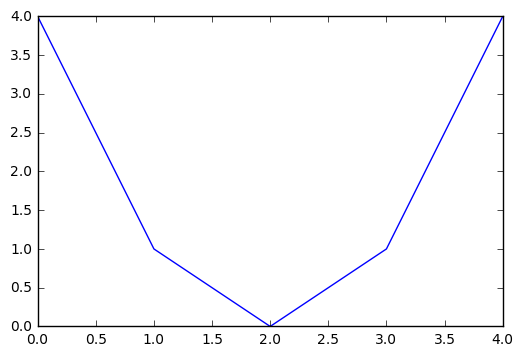

In [59]:
pt['s'].plot();

## But wait, there's more... for another day

- Transform to/from other table-like objects (Pandas DataFrame, numpy structured array, LSST)
- Subclass for custom applications (documentation example of params)
- Unified interface for I/O (ASCII, FITS, votable)